# Emoji and NLP Analysis of the Final Presidential Debate

This notebook details the approaches and the conclusions of the analysis of the final presidential debate using the Twitter Streaming API. This work was completed for <a href = 'https://prismoji.com/'>Prismoji</a> with the aim of understanding how twitter users conveyed sentiment for the debate with emojis. 

<b>This notebook covers:</b>
1. Data Cleaning
2. Visualizations 
3. Conclusions

The scripts for acquiring the data are attached in the github page.

<b>Our approach was two-fold:</b>
1. Use tweet volume to understand what users found important. <u>We made the assumption that higher volume of tweets correlate with user interest.</u>
2. We also counted the frequency of emojis used relating to each candidate and the frequency used through time, also assuming that the higher the usage the more important it is.


<b> Our Conclusions:</b>
1. Donald Had a much higher volume of tweets overall, relating to both negative and position reactions to him. This also carried over to tweets, which he also had a much higher volume of. 
2. Certain emojis are highly correlated with certain topics. For example: the clapping hands emoji is very correlated with women's right issues and Hillary in general. In a clearere example, the train emoji is used when Trump is seen to be doing well.
3. Aside from english, the top 4 languages are comprised of Spanish, Portuguese, and French. This might be due with a certain community's involvement with this election or areas where twitter is popular.


<u><b>I've also created an interactive plot using plot.ly which shows how different topics influenced twitter usage that you can check out <a href = 'https://plot.ly/~fernanhid/3/'>HERE<a>.<b></u>

### Aside from that, I hope you enjoy this notebook!

# <u> 1. Loading Dependencies

In [39]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from collections import Counter
pd.options.mode.chained_assignment = None 

%matplotlib inline

In [54]:
# Make all my plots 538 Style
plt.style.use('fivethirtyeight')

# <u> 2. Retrieving Data

The data was acquired tweets from the Twitter Streaming AP and saved into the Non-SQL database MongoDB.<br> I then pulled from this database to do the analysis.

In [1]:
from pymongo import MongoClient

client = MongoClient()

In [6]:
tweets = client.tweets

In [8]:
total_tweets = []
count = 0
for i in tweets.debate_hashtags.find({}):
    count += 1
    total_tweets.append(i)
    if count % 100000 == 0:
        print count

100000
200000
300000
400000
500000


In [10]:
count = 0
for i in tweets.twitter_handles.find({}):
    count += 1
    total_tweets.append(i)
    if count % 100000 == 0:
        print count

100000
200000
300000
400000
500000


# <u> 3. Transforming Data to DataFrame

The data is now in dictionary format but we want it to be in dataframe format to make it easier to manage.

<b>Steps:</b>
1. Create a function to turn dates into  datetime objects
2. Go through each tweet and select the relevant field for our dataframe
3. Save the new dataframe using pickle to keep the datetime objects

In [39]:
# 1. Create a Datetime Function

def get_date(tweet):
    try:
        t = datetime.strptime('2016 ' +' '.join(tweet['created_at'].split('+')[0].split(' ')[1:-1]),\
                '%Y %b %d %H:%M:%S')
    except:
        t = 'none'
        
    return t

In [56]:
# 2. Go through Each Tweet and Select Relevant Fields

text = []
lang = []
date = []
user_id = []
tweet_id = []
user_name = []
phone_source = []
source = []
followers = []
geo = []
for tweet in total_tweets:
    try:
        text_ = tweet['text']
        lang_ = tweet['lang']
        date_ = get_date(tweet)
        user_id_ = tweet['user']['id']
        tweet_id_ = tweet['id']
        user_name_  = tweet['user']['screen_name']
        source_ = tweet['source'].split('>')[1].split('<')[0]
        followers_ = tweet['user']['followers_count']
        geo_ = tweet['geo']
        
        text.append(text_)
        lang.append(lang_)
        date.append(date_)
        user_id.append(user_id_)
        tweet_id.append(tweet_id_)
        user_name.append(user_name_)
        source.append(source_)
        followers.append(followers_)
        geo.append(geo_)
    except:
        pass
    
df = pd.DataFrame()
df['text'] = text
df['lang'] = lang
df['date'] = date
df['user_id'] = user_id
df['tweet_id'] = tweet_id
df['user_name'] = user_name
df['source'] = source
df['followers'] = followers
df['geo'] = geo

In [58]:
# 3. Pickle the Data

#df.to_pickle('final_non_processed.pkl')

<b>Dataframe:

In [5]:
#df = pd.read_pickle('final_non_processed.pkl')

In [6]:
df.head()

,text,lang,date,user_id,tweet_id,user_name,source,followers,geo
0,Fully expecting tonight's #debate to be awful:...,en,2016-10-19 23:37:01,1592276773,788886703352274945,RealMikeKeaton,Twitter for iPhone,178,None
1,@TheLadyHarley Bring On The last #debate!\n( s...,en,2016-10-19 23:37:01,167985567,788886704610500608,TheLadyHarley,Twitter Web Client,1741,None
2,#Debate this! #Fukushima's irradiated food rej...,en,2016-10-19 23:37:01,124896632,788886704539041792,PositivelyJoan,Twitter Web Client,7713,None
3,@DrJillStein Slams #HillaryClinton’s Foreign P...,en,2016-10-19 23:37:01,3237425269,788886703314395136,PeoplesMediaLA,TweetDeck,3211,None
4,@USAforTrump2016 @AC360 @Trump4Hope @USATODAY ...,und,2016-10-19 23:37:01,267415036,788886704614699008,HoffmanMarie,Twitter for iPad,87,None


# <u> 4. Cleaning the Data

<b>Things to Consider:</b>
1. Data was acquired using two twitter streams so there may be duplicate tweets
2. Twitter has plenty of retweets and in this project we want only original tweets

<br><br>
<b>Implementation:</b>

1.Dropping Duplicates

In [7]:
no_duplicates = df.drop_duplicates(['text', 'user_name', 'user_name'])

# Reseting the Index
reset_df = no_duplicates.reset_index(drop = True)

In [8]:
print'Percent of duplicate rows deleted: %r'%(round(((df.shape[0] - no_duplicates.shape[0] )/float(df.shape[0])),3)*100)

Percent of duplicate rows deleted: 5.5


2.Getting Rid of Retweets

In [9]:
df = reset_df[['RT @' not in i for i in reset_df.text]]

In [10]:
print'Percent of retweeeted rows deleted: %r'%(round(((reset_df.shape[0] - df.shape[0] )/float(reset_df.shape[0])),3)*100)

Percent of retweeeted rows deleted: 60.4


<b> 60 Percent of the Tweets where Retweets!!

In [12]:
#df.to_pickle('final_df.pkl')

# <u> 4. Exploratory Analysis

Before diving into the emoji and text analysis we can look at the different characteristics of the users

<b> Things to Consider:</b>
1. Language
2. Source
3. Number of Followers

In [13]:
#df = pd.read_pickle('final_df.pkl')

### A. User Exploration

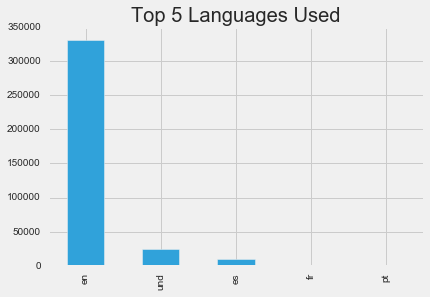

In [14]:
_ = df.lang.value_counts()[:5].plot(kind = 'bar')
_ = plt.title('Top 5 Languages Used')

The Top 5 Languages are english, undetermines, spanish, french, and portuguese

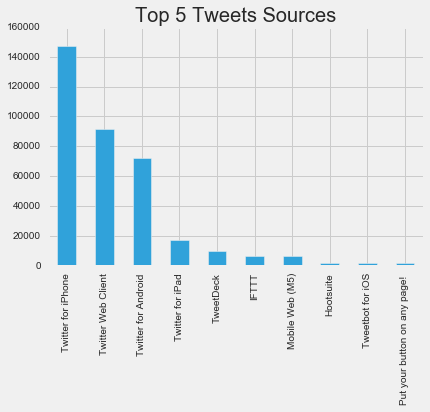

In [15]:
_ = df.source.value_counts()[:10].plot(kind = 'bar')
_ = plt.title('Top 5 Tweets Sources')

The biggest tweet sources are Iphone, Computers, and Android

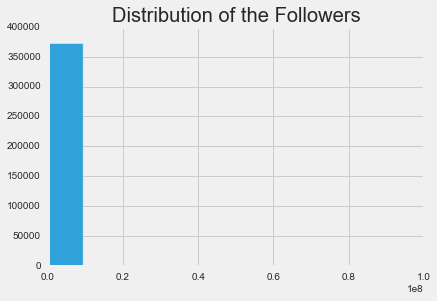

In [16]:
_ = df.followers.hist()
_ = plt.title('Distribution of the Followers')

Most of the # of followers are near zero while there are some outliers!

# <u> 5. Feature Engineering

<b>Things to Consider:</b>
1. We will first turn the date column into datetime objects to make them more managable
2. Next We will Create Features that tell us if a Hillary, Trump or the Word Debate is being Used <br>
We will do this by creating a function to detect certain words and create dummy variables
<br><br>

<b> Implementation:</b>


### A. Creating a datetime Column

In [17]:
df['new_date'] = [datetime.strptime(date.strftime('%Y %b %d, %H:%M'), '%Y %b %d, %H:%M') - timedelta(hours = 4)\
                  for date in df.date]

### B. Features of Word Mentions

In [18]:
# Create Function
import re
def word_in_text(words, text):
    words = [word.lower() for word in words]
    text = text.lower()
    
    for word in words:
        if re.search(word, text):
            return True
    return False

In [19]:
# Signal when a Certain Word is Mentioned
df['debate'] = [1 if word_in_text(['debate'], text) else 0 for text in df.text]
df['trump'] = [1 if word_in_text(['trump'], text) else 0 for text in df.text]
df['hillary'] = [1 if word_in_text(['hillary'], text) else 0 for text in df.text]

### C. Create Emoji Features

We will Create Features that help up understand the ways that tweeters are using emojis

<b>Features:</b>
1. Whether a tweet has emojis
2. A feature that lists the emojis used in those rows

<b> Methodology:</b>
1. I will create a dataframe of emojis and their names that I scrapped from http://unicode.org/emoji/charts/full-emoji-list.html. 
2. I will use use the dataframe to create a function to detect if an emoji is used
3. Create a Dataframe that only contains tweets with emojis
4. Create a feature listing of all the emojis on that row

<b> 1. Creating a dataframe with emojis

In [20]:
# Scrapping the Emoji Chart

import requests
from bs4 import BeautifulSoup as bf
x = bf(requests.get('http://unicode.org/emoji/charts/full-emoji-list.html').text, 'lxml')
code = []
unicode_ = []
name = []
for i in x.find_all('tr'):
    try:
        code.append('U000'+i.find('td', class_ = 'code').a.text.split(' ')[0].split('U+')[1])
        unicode_.append(i.find('td', class_ = 'chars').text)
        name.append(i.find('td', class_ = 'name').text)
    except:
        pass
    
    
# The Emoji Dataframe    
emoji = pd.DataFrame({'code': code, 'names': name, 'unicode' : unicode_})

In [21]:
emoji.head()

,code,names,unicode
0,U0001F600,grinning face,😀
1,U0001F601,grinning face with smiling eyes,😁
2,U0001F602,face with tears of joy,😂
3,U0001F923,rolling on the floor laughing,🤣
4,U0001F603,smiling face with open mouth,😃


<b> 2.  Making the Function To Identify if there is an emoji in a tweet

In [22]:
# Function to See if a String has an Emoji in It
def check_emoji_lst(string):
    for emoji_utf in emoji['unicode']:
        if emoji_utf in string:
            return True
    return False

Make a Column if a tweet has an Emoji


In [23]:
df['if_emoji'] = [1 if check_emoji_lst(i) == True else 0 for i in df.text]

<b> 3. Create an Emoji Only Dataframe

In [24]:
emoji_only_df = df[df.if_emoji == 1].reset_index(drop=True)

<b> 4. Create a Feature Listing the Emojis in the Tweet

In [25]:
# Make Column that Lists the Unique Emojis in the Tweet
x = {}
master_lst = []
for index,text in enumerate(emoji_only_df.text):
    temp = []
    for i,uni in  enumerate(emoji['unicode']):
        if uni in text:
            temp.append(uni)
            
            try:
                x[index] += [uni]
            except:
                x[index] = [uni]
    master_lst.append(temp)

The new feature:

In [26]:
emoji_only_df['emojis'] = master_lst

In [27]:
emoji_only_df[['text', 'emojis', 'new_date']].head()

,text,emojis,new_date
0,Settled in in Donnybrook for a fun night of #d...,"[🍫, ☕]",2016-10-19 19:37:00
1,Watching the #debate in my US government class 😅,[😅],2016-10-19 19:37:00
2,.@Cernovich \n@HillaryClinton Is Going To Free...,"[🏽, 👇, 👇🏽]",2016-10-19 19:37:00
3,Well would you look what happens when a congre...,[😳],2016-10-19 19:37:00
4,I'm watching the #debate tonight followed by #...,[😮],2016-10-19 19:37:00


# <u> 6. Visualizing Results

<b> Things to Look For:</b>
1. The density of tweets for different segments e.g. tweets mentioning Trump vs Clinton
2. Volume of total tweets mentioning a specific topic
3. Emojis that are higher associated with each candidate
4. Top Emojis per candidate

To make nice plots: </b>

In [56]:
rc={'xtick.labelsize': 30, 'ytick.labelsize': 30, 'axes.labelsize': 25, 'font.size': 25, 
    'legend.fontsize': 35.0, 'axes.titlesize': 40, "figure.figsize": [35, 14]}
sns.set(rc = rc)

### A. Plotting Volume

<b> Total Volume of Tweets

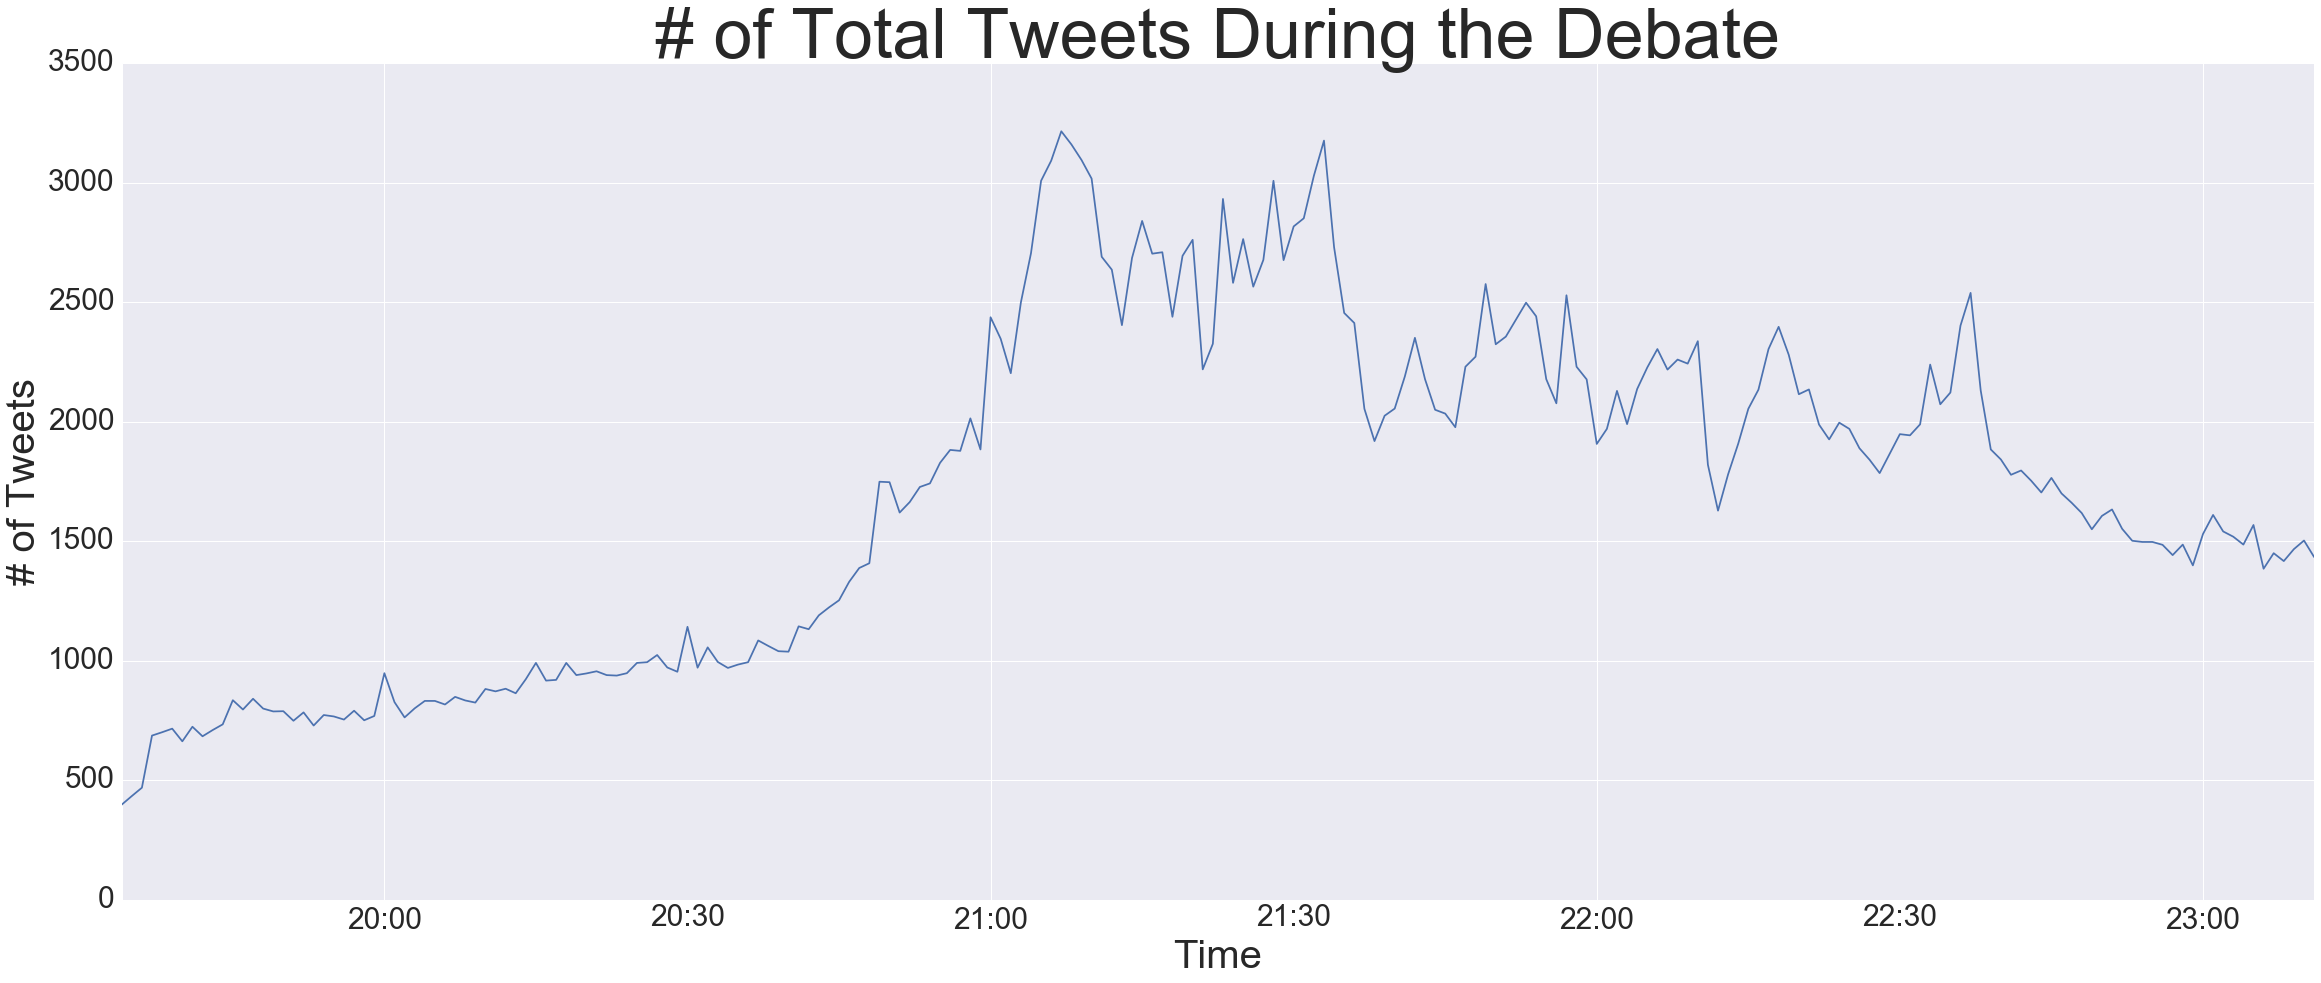

In [29]:
df.groupby('new_date').count()['text'][:-1].plot()
plt.title('# of Total Tweets During the Debate', size = 70)
plt.xlabel('Time', size = 40)
_ = plt.ylabel('# of Tweets', size = 40)

<b> Volume of Tweets for Each Candidate

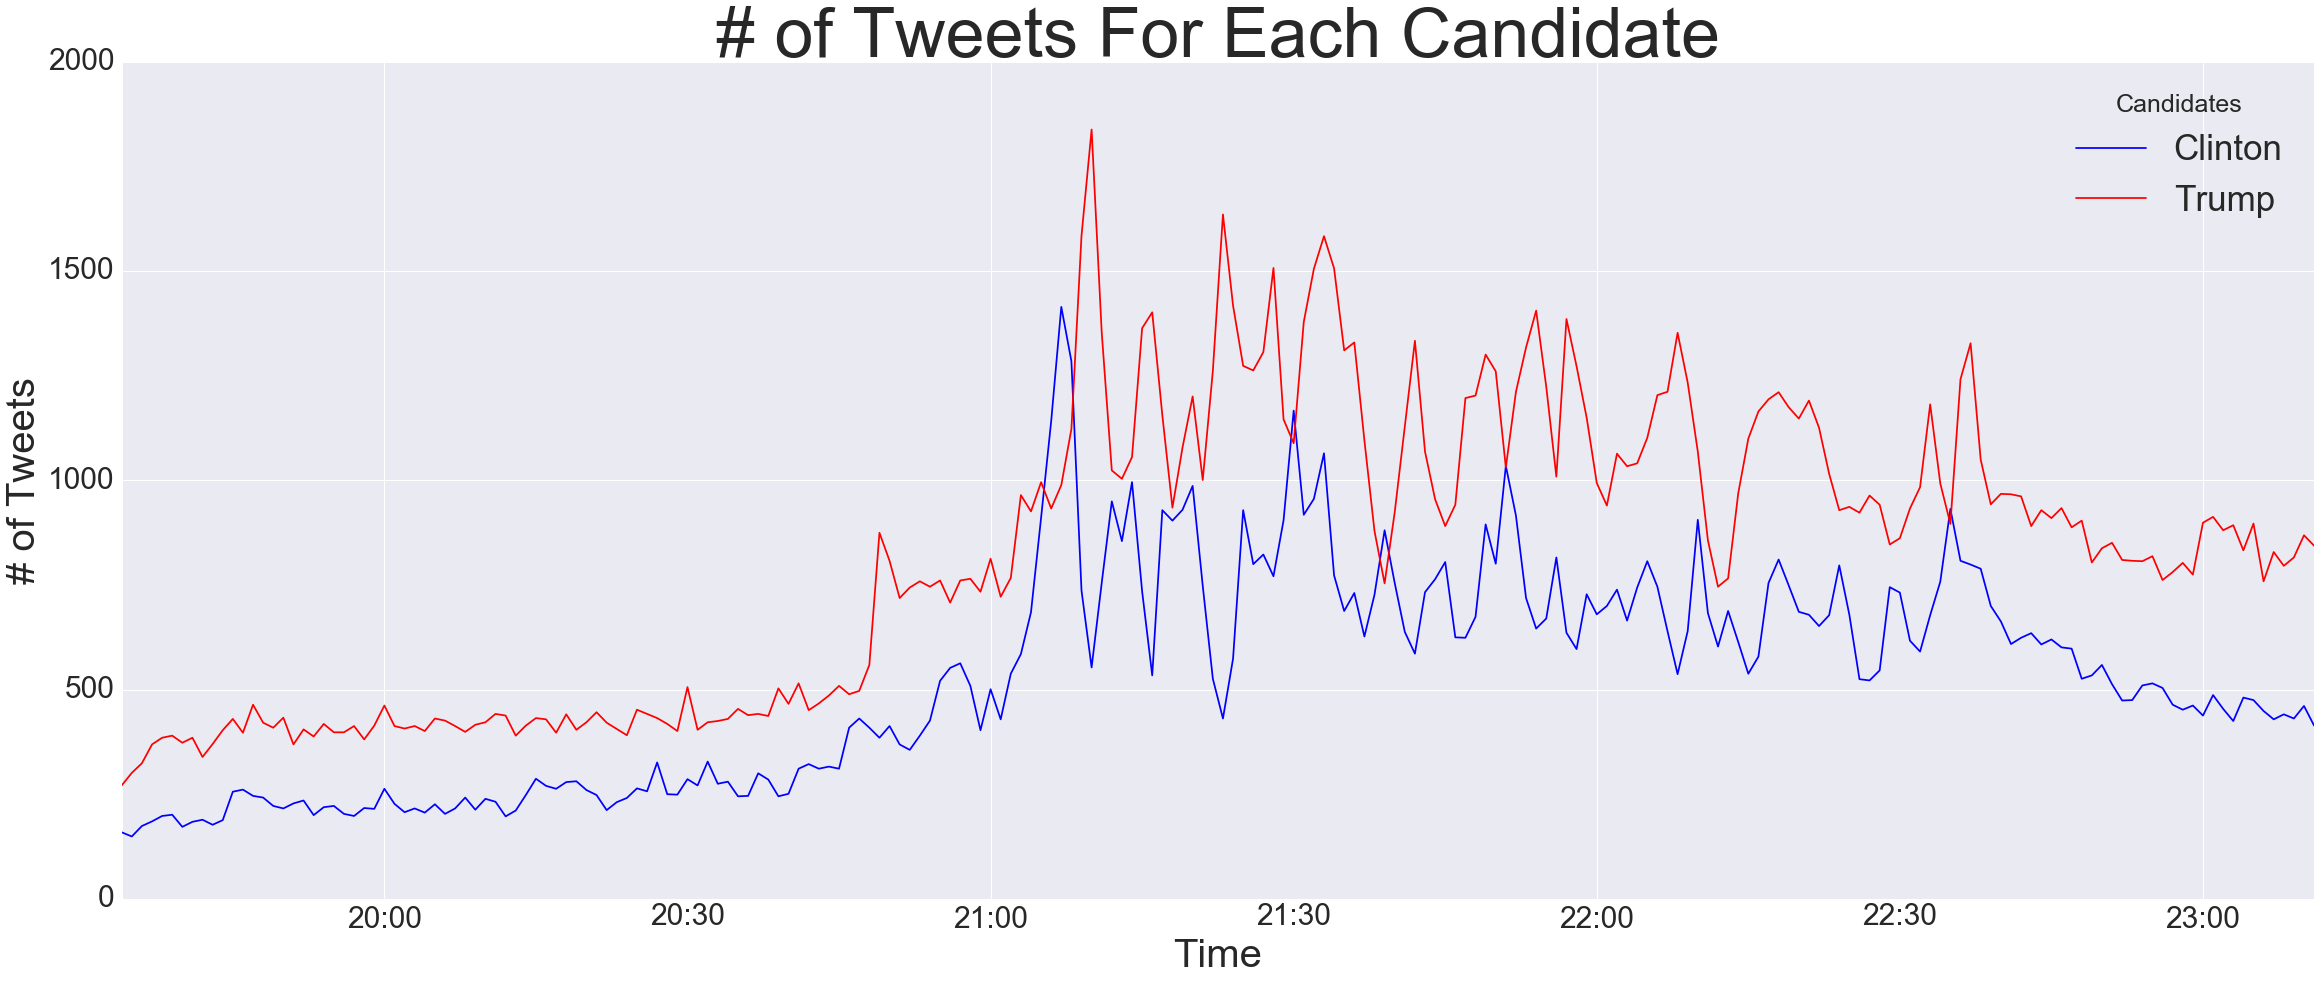

In [30]:
df[df.hillary == 1].groupby('new_date').count()['text'][:-1].plot(label = 'Clinton', color = 'blue')
df[df.trump == 1].groupby('new_date').count()['text'][:-1].plot(label = 'Trump', color = 'red')
plt.legend(title = 'Candidates')
plt.title('# of Tweets For Each Candidate', size = 70)
plt.xlabel('Time', size = 40)
_ = plt.ylabel('# of Tweets', size = 40)

<u> Takeaways: </u>
1. Trump has more mentions on twitter than Hillary. Hillary only passes him a handful of times but in general Trump has a higher volume of mentions.
2. During the debate the volume gets volatile and the mentions for each candidate become <u>inversely</u> related.

<i>It will be interesting to see what the spikes correspond to.

#### Analyzing Themes Through Volume

We will make a feature for each mention of the word relating to a topic in the debate

In [31]:
df['hombre'] = [1 if ('hombre' in i) == True else 0 for i in  df.text] 
df['white'] = [1 if ('white' in i) == True else 0 for i in  df.text] 
df['puppet'] = [1 if ('puppet' in i) == True else 0 for i in  df.text] 
df['ripped'] = [1 if ('ripped' in i) == True else 0 for i in  df.text] 
df['chinese'] = [1 if ('chinese' in i) == True else 0 for i in  df.text] 
df['rigged'] = [1 if ('rigged' in i) == True else 0 for i in  df.text] 
df['nasty'] = [1 if ('nasty' in i) == True else 0 for i in  df.text] 
df['handshake'] = [1 if ('handshake' in i) == True else 0 for i in  df.text] 
df['sexual'] = [1 if ('sexual' in i) == True else 0 for i in  df.text] 
df['women'] = [1 if ('women' in i) == True else 0 for i in  df.text] 
df['vegas'] = [1 if ('vegas' in i) == True else 0 for i in  df.text] 
df['bigly'] = [1 if ('bigly' in i) == True else 0 for i in  df.text] 
df['sniff'] = [1 if ('sniff' in i) == True else 0 for i in  df.text] 
df['abortion'] = [1 if ('abortion' in i) == True else 0 for i in  df.text] 

We Do a Groupby for each topic and plot them together to compare

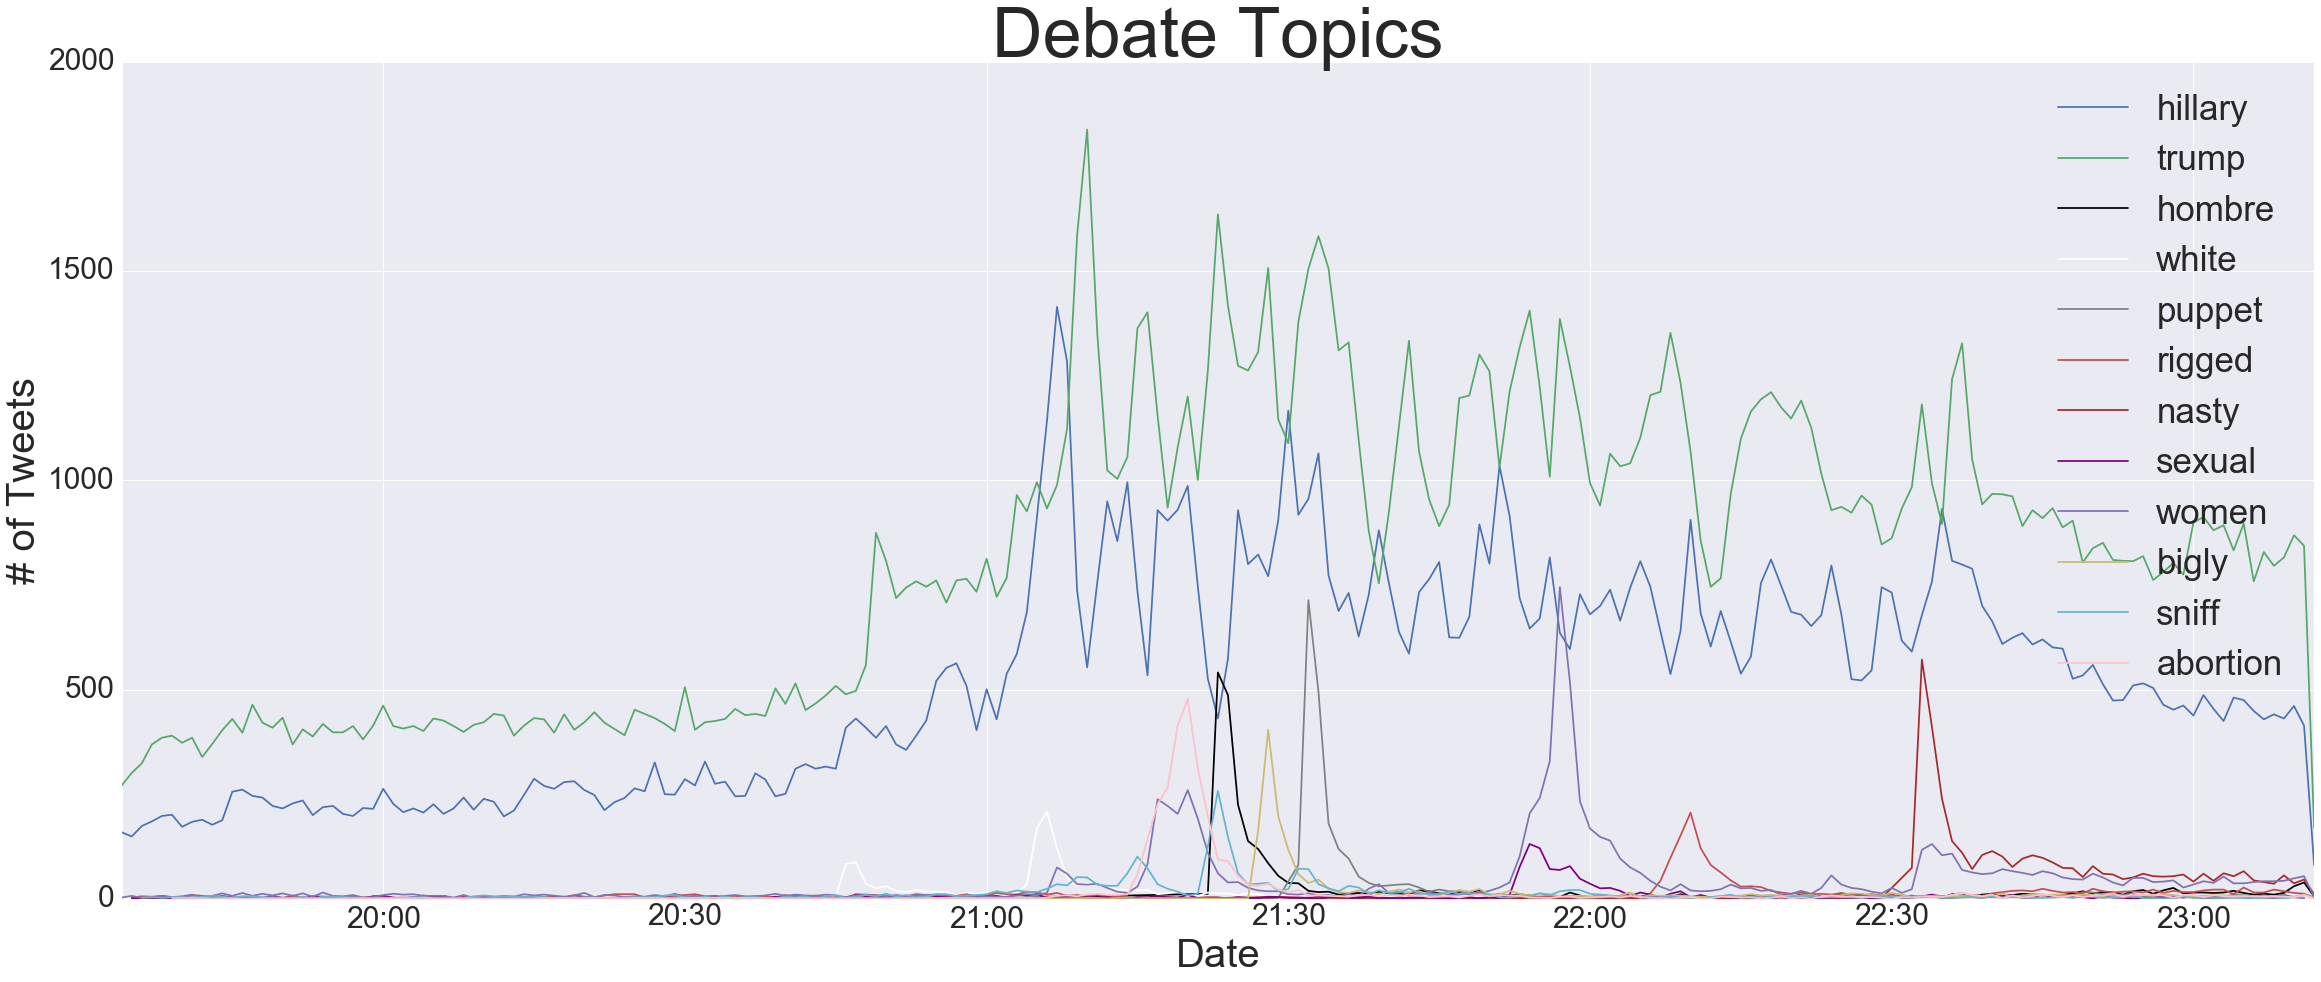

In [32]:
df[df.hillary == 1].groupby('new_date').count()['text'].plot(label = 'hillary')
df[df.trump == 1].groupby('new_date').count()['text'].plot(label = 'trump')

df[df.hombre == 1].groupby('new_date').count()['text'].plot(label = 'hombre', color= 'black')
df[df.white == 1].groupby('new_date').count()['text'].plot(label = 'white', color = 'white')
df[df.puppet == 1].groupby('new_date').count()['text'].plot(label = 'puppet', color = 'grey')
df[df.rigged == 1].groupby('new_date').count()['text'].plot(label = 'rigged')
df[df.nasty == 1].groupby('new_date').count()['text'].plot(label = 'nasty', color = 'brown')
df[df.sexual == 1].groupby('new_date').count()['text'].plot(label = 'sexual', color = 'purple')
df[df['women'] == 1].groupby('new_date').count()['text'].plot(label = 'women')
df[df['bigly'] == 1].groupby('new_date').count()['text'].plot(label = 'bigly')
df[df['sniff'] == 1].groupby('new_date').count()['text'].plot(label = 'sniff')
df[df.abortion == 1].groupby('new_date').count()['text'].plot(label = 'abortion', color = 'pink')


plt.legend()
plt.title('Debate Topics', size = 70)
plt.xlabel('Date', size = 40)
plt.ylabel('# of Tweets', size = 40)

There is a lot going on here!<br>
We can see how different topics of the debate correlate to mentions of each candidate.<br>
For a full themes analysis, I constructed a plot.ly graph that you can see <u><a href="https://plot.ly/~fernanhid/3/">here</a></u> but for this graph we can have 5 takeaways. 
<br>

<u>We Can take 5 Takeaways:</u>
1. The top 4 most mentioned topics the most are all correlated with Trump, and these are nasty, women, puppet, and hombres.
2. I actually tried to find the topics in which Hillary passed Trump but there is not a defining topics but rather when she talked.
3. The most persistent topic is women which has multiple peaks and comes up in all the different women related topics including abortion, the sexual harrasment charges, and Trump's comment about women.

## B. Plotting Emojis

<b> Things to Consider:</b>
1. When the volume of tweets with emojis tend to peak.
2. Explore How Specific Emojis trend over time
3. Top Emojis for each candidate
4. How Any Emoji is related with each candidate

<b>1. Volume of Emoji Tweets</b>

<u>Steps:</u> <br>
a. Normalize tweets with emojis and the non-emoji tweets<br>
b. Plot both in a scale of 0-1

In [33]:
# a. Normalize data
em = df[df.if_emoji == 1].groupby('new_date').count()
all_ = df.groupby('new_date').count()

#Normalize Emoji Tweets
em_max = em.text.max()
em['adjust_tweets'] = [i/float(em_max) for i in em.text]

#Normalize All Tweets
all_max = all_.text.max()
all_['adjust_tweets'] = [i/float(all_max) for i in all_.text]

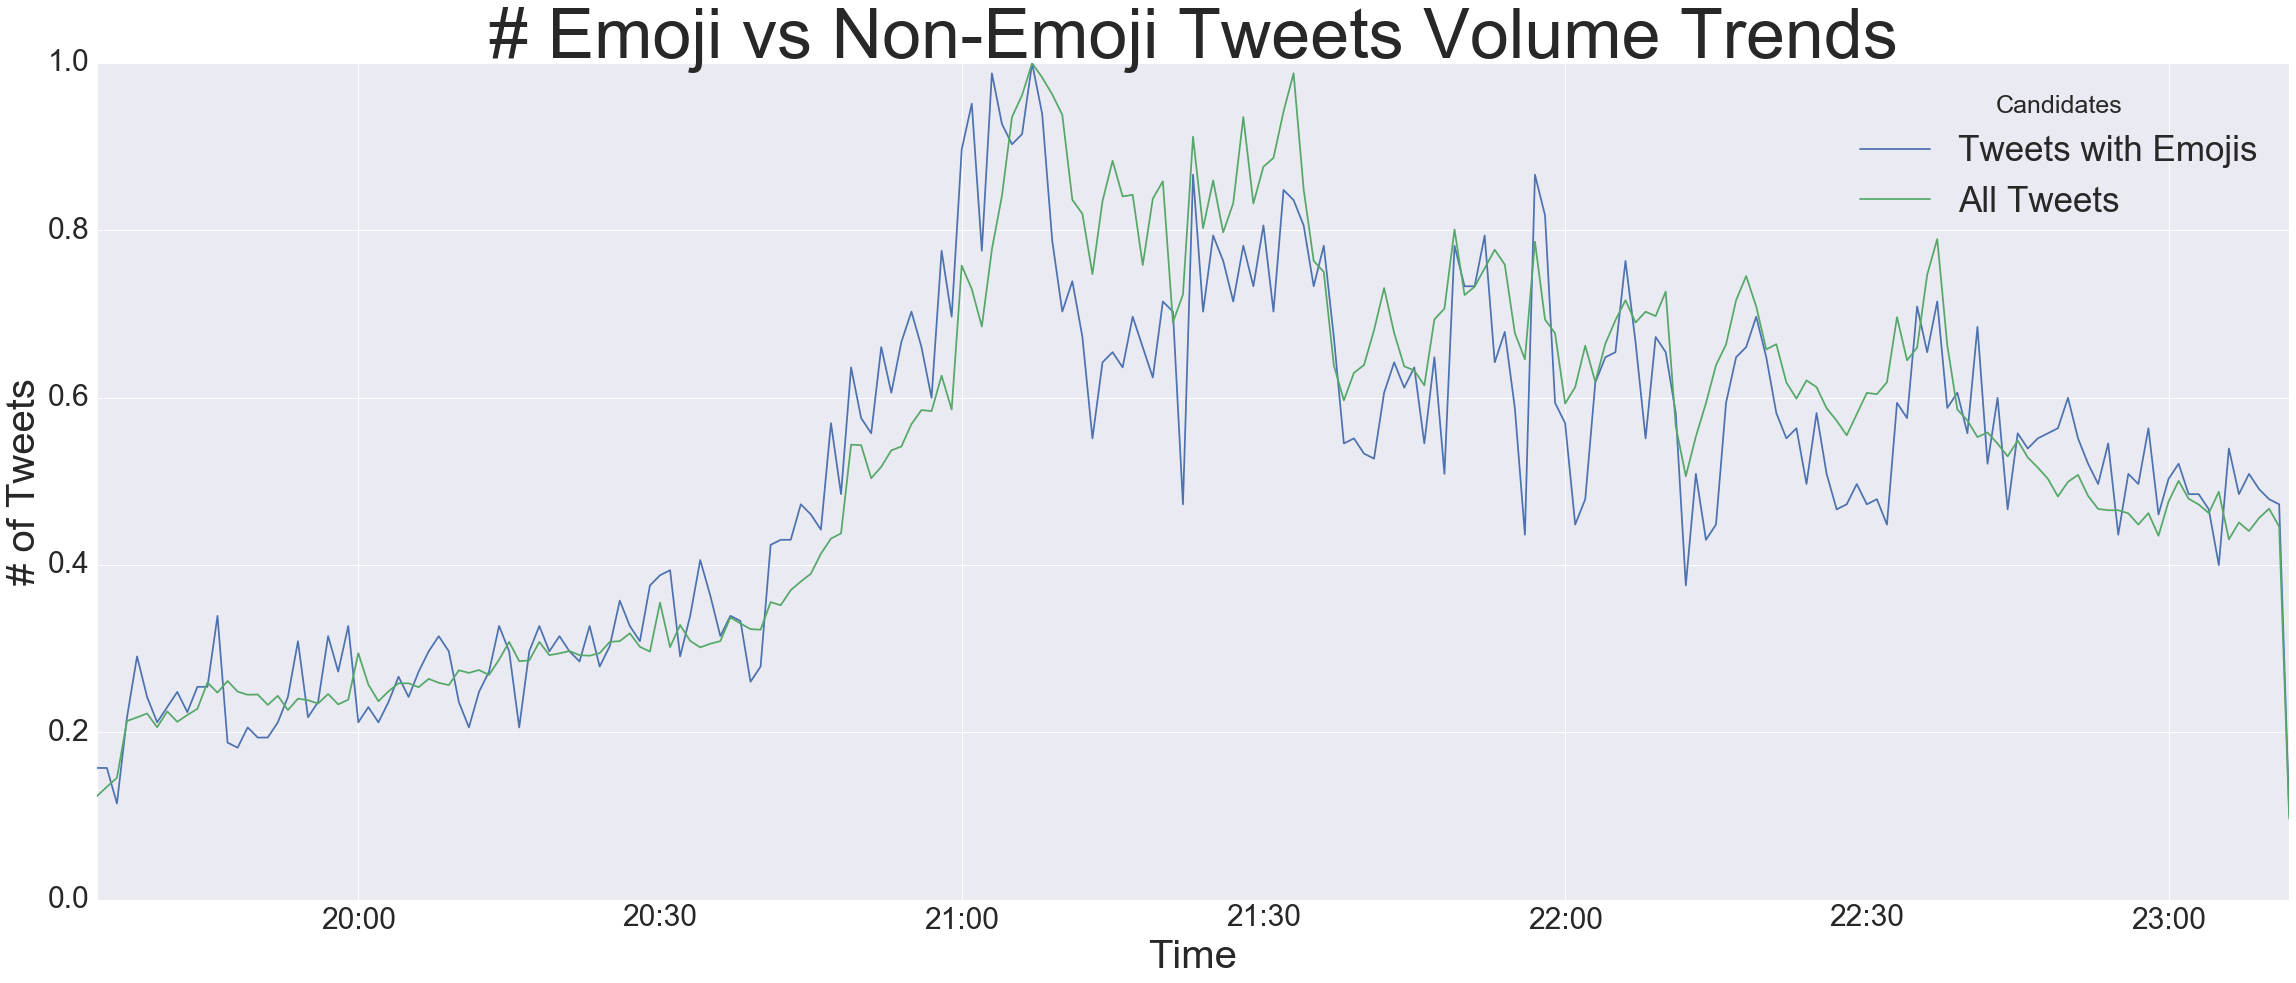

In [36]:
#b. Plotting Data
em.adjust_tweets.plot(label = 'Tweets with Emojis')
all_.adjust_tweets.plot(label = 'All Tweets')
plt.legend(title = 'Candidates')
plt.title("# Emoji vs Non-Emoji Tweets Volume Trends", size = 70 )
plt.xlabel('Time', size = 40)
plt.ylabel('# of Tweets', size = 40)

The tweets with emojis and the ones without emojis follow a very similar pattern. There are no outliers here to dig further into.

<b> 2. Top Emojis Per Candidate</b>

<u>Steps:</u><br>
a. Create dataframes that contain each candidate exclusively<br>
b. Create a single list of all the emojis for each candidate<br>
c. Count and Plot the frequency of each emoji used

In [35]:
#a. Create DataFrames
trump_emoji = emoji_only_df[(emoji_only_df.hillary == 0 )&(emoji_only_df.trump == 1 )]
hillary_emoji = emoji_only_df[(emoji_only_df.hillary == 1 )&(emoji_only_df.trump == 0 )]

<i> b. Making a List of Emojis for Trump, Hillary, and all Emoji Tweets</i>

In [40]:
# Trump
trump_flat = [val for sublist in trump_emoji.emojis for val in sublist]
top_emoji_trump = Counter(trump_flat).most_common()[:15]
trump_emoji_df = pd.DataFrame({'emoji': [i[0] for i in top_emoji_trump], '#':[i[1] for i in top_emoji_trump] })

In [64]:
# Hillary
hillary_flat = [val for sublist in hillary_emoji.emojis for val in sublist]
top_emoji_hillary = Counter(hillary_flat).most_common()[:15]
hillary_emoji_df = pd.DataFrame({'emoji': [i[0] for i in top_emoji_hillary], '#':[i[1] for i in top_emoji_hillary] })

In [65]:
# All Tweets
emojis_flat = [val for sublist in master_lst for val in sublist]
top_emoji = Counter(emojis_flat).most_common()[:15]
all_emoji_df = pd.DataFrame({'emoji': [i[0] for i in top_emoji], '#':[i[1] for i in top_emoji] })

<i>c. Plotting 

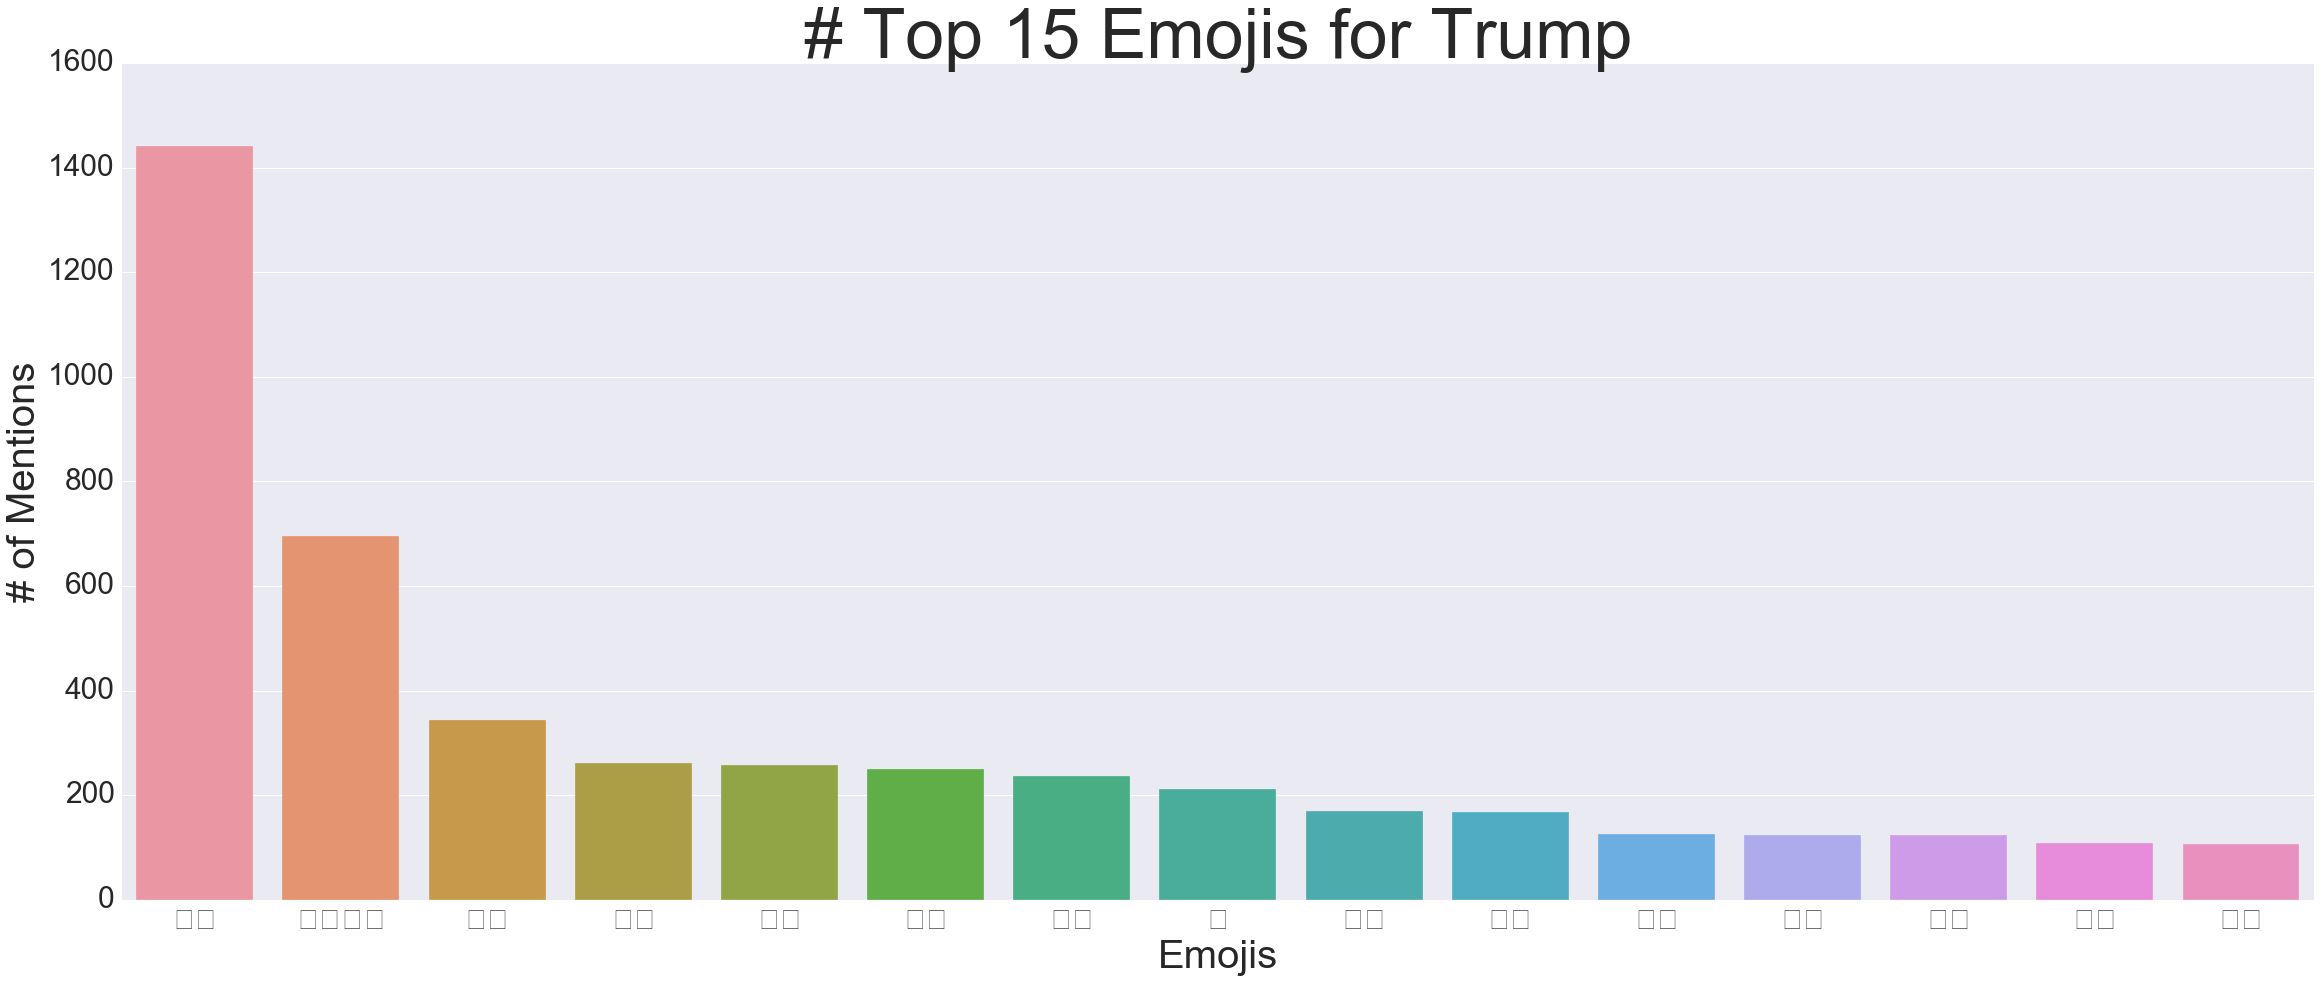

In [58]:
sns.barplot(x = trump_emoji_df.emoji, y = trump_emoji_df['#'], )
plt.title("# Top 15 Emojis for Trump", size = 70 )
plt.ylabel('# of Mentions', size = 40)
_ = plt.xlabel('Emojis', size = 40)

In [59]:
trump_emoji_df

,#,emoji
0,1441,😂
1,695,🇺🇸
2,343,🤔
3,261,👍
4,257,🙄
5,251,🏻
6,236,🏼
7,211,❤
8,170,👏
9,168,🙏


<b> These all seems intuitive however, one does not and that is the train.<br>
Let's take a closer look:

In [60]:
#Trump Train!!
l = emoji_only_df[[(u'\U0001f682' in i) for i in emoji_only_df.emojis]]
print l.iloc[1].text

This is going to be a rough night for Hillary #debatenight #debate #TrumpTrain🚂💨🇺🇸 #MAGA #TrumpPence16 #MakeAmericaGreatAgain


Now we learn the association of trump with the train since it is used as #TrumpTrain

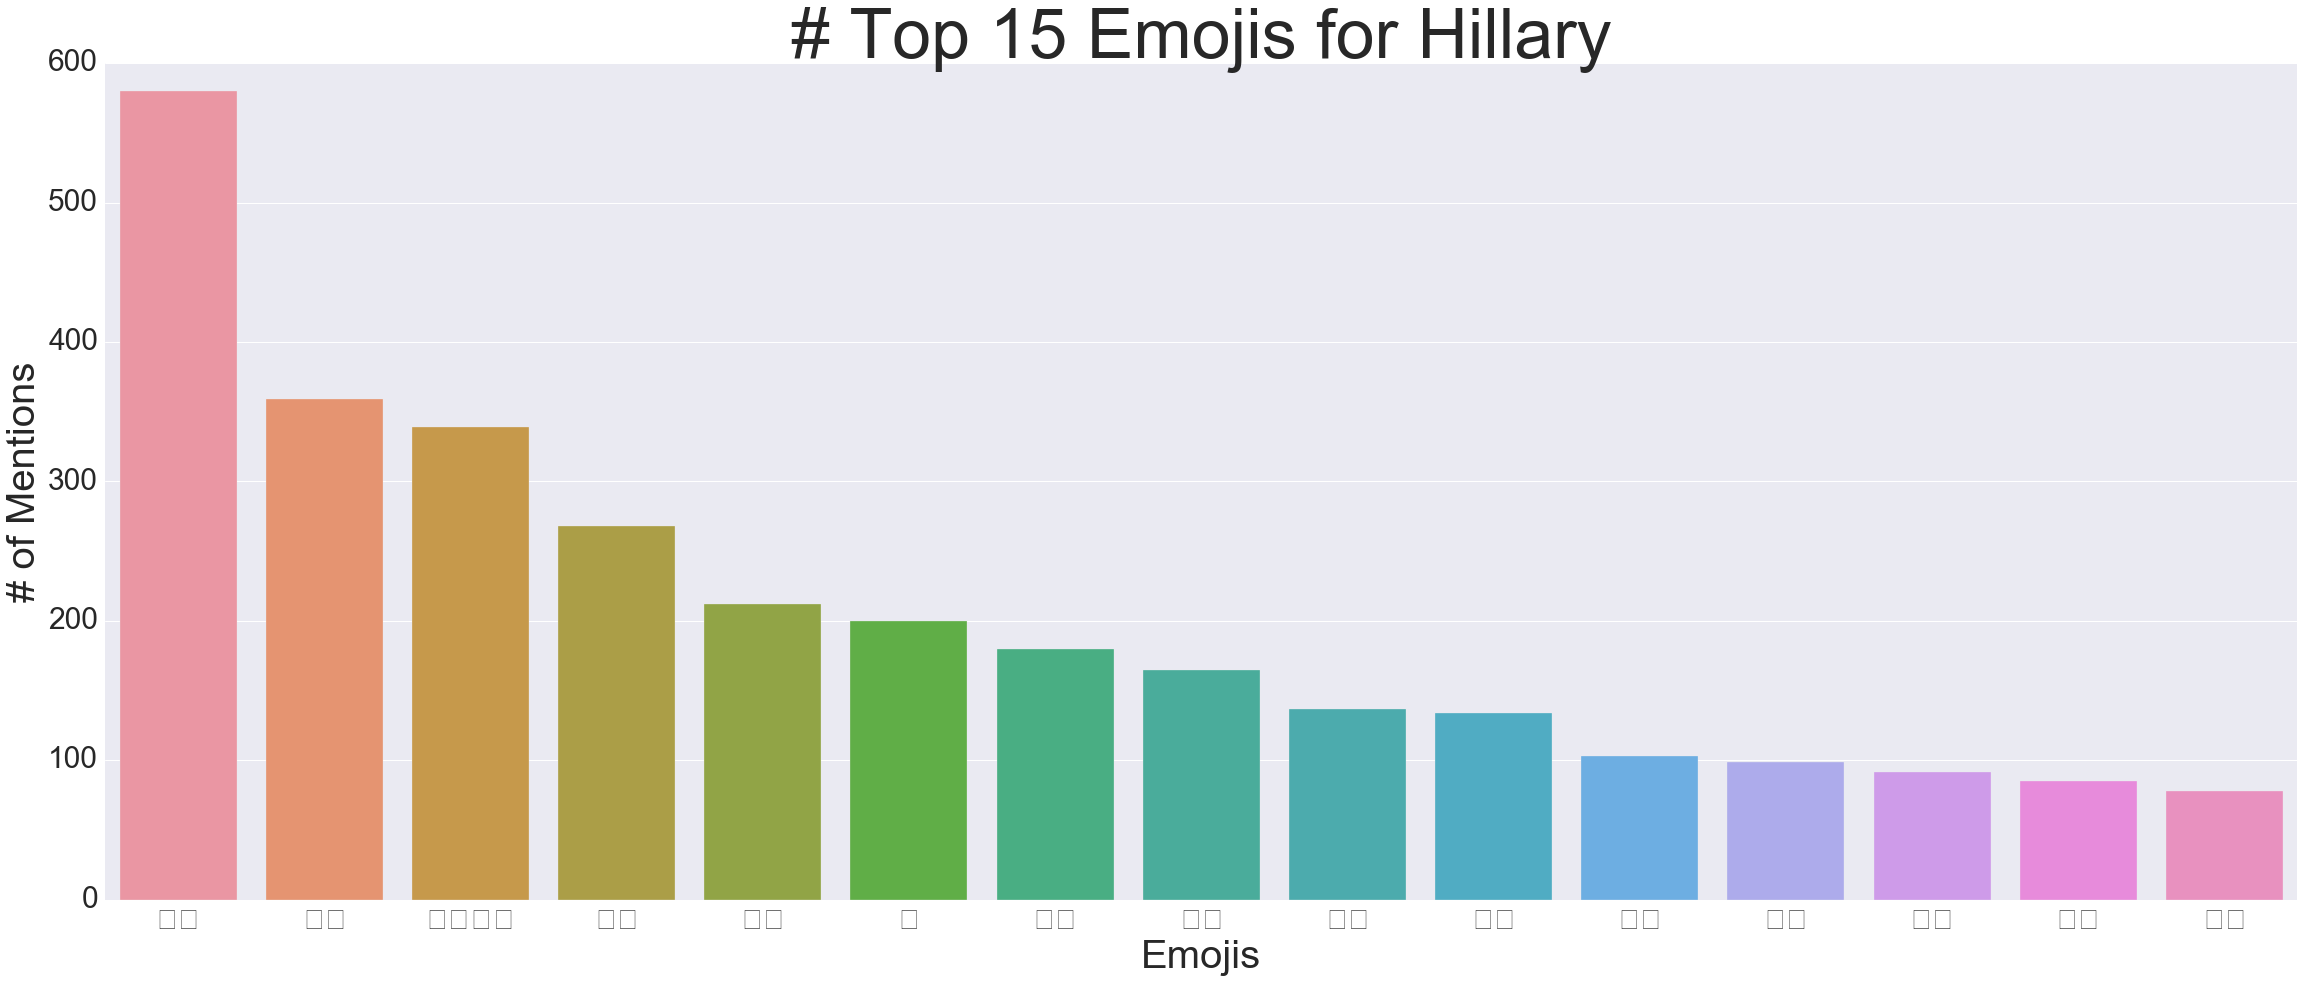

In [62]:
sns.barplot(x = hillary_emoji_df.emoji, y = hillary_emoji_df['#'], )
plt.title("# Top 15 Emojis for Hillary", size = 70 )
plt.ylabel('# of Mentions', size = 40)
_ = plt.xlabel('Emojis', size = 40)

In [63]:
hillary_emoji_df

,#,emoji
0,580,😂
1,359,👏
2,339,🇺🇸
3,268,🏼
4,212,🏻
5,200,❤
6,180,👍
7,165,🙌
8,137,🤔
9,134,🏽


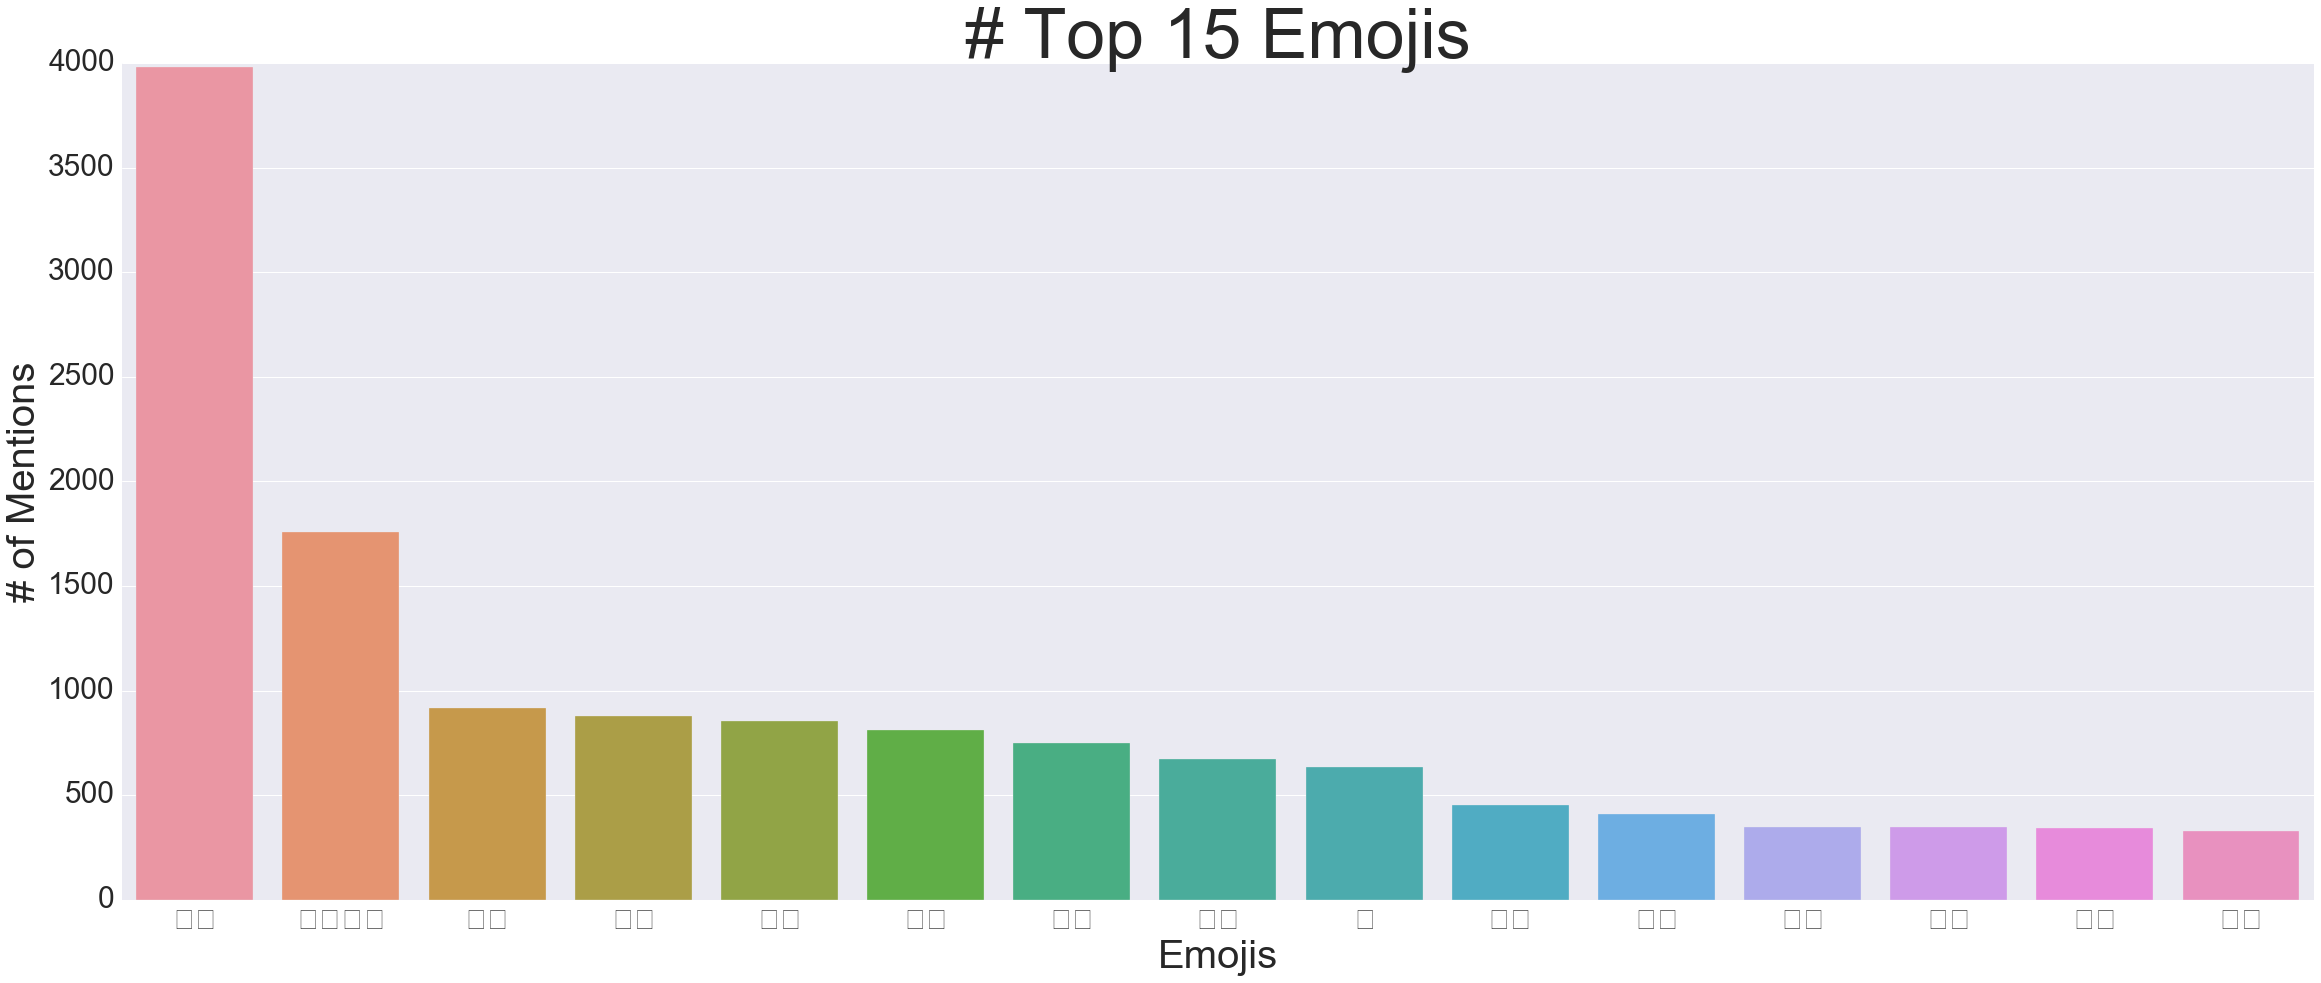

In [69]:
sns.barplot(x = all_emoji_df.emoji, y = all_emoji_df['#'])
plt.title("# Top 15 Emojis", size = 70 )
plt.ylabel('# of Mentions', size = 40)
_ = plt.xlabel('Emojis', size = 40)

In [70]:
all_emoji_df

,#,emoji
0,3981,😂
1,1757,🇺🇸
2,915,👏
3,880,🤔
4,853,🏼
5,813,🏻
6,748,🙄
7,675,👍
8,634,❤
9,451,🏽


<b>Things to consider:</b>
1. The top top 3 emojis are the crying laughing emoji, the flag emoji, and the clapping hands emoji
2. There are also color swatches that come up which are the skin tones of the emojis used. <u>This could interesting in another analysis.

### 3. The Story of an Emoji

We will follow the life cycle of the mentions of two of the three top used emojis- the American Flag and the clapping hands. The top used emoji (laughing smiling face) has been analyzed in prior papers and seems to be used for both happy and sad moments, so we won't go into it here.

<u>Steps:</u>
1. We will normalize the emoji usage to compare against the overall usage like before. 
2. We will plot the frequency of usage vs total tweets to see when these spikes happenned.



<i> A. USA Flag Emoji

In [119]:
emoji_only_df['usa'] = [1 if (u'\U0001f1fa' u'\U0001f1f8' in emojis) else 0 for emojis in emoji_only_df.emojis]
groupby_usa = emoji_only_df[emoji_only_df.usa == 1].groupby('new_date').count()
groupby_usa['adjusted_tweets'] = [i/float(groupby_usa.text.max()) for i in groupby_usa.text]

In [120]:
# Normalizing Data to Make Trend Comparisons Easier

groupby_trump = df[(df.trump == 1) & (df.hillary == 0)].groupby('new_date').count()
groupby_trump['adjusted_tweets'] = [i/float(groupby_trump.text.max()) for i in groupby_trump.text]

groupby_hillary = df[(df.trump == 0) & (df.hillary == 1)].groupby('new_date').count()
groupby_hillary['adjusted_tweets'] = [i/float(groupby_hillary.text.max()) for i in groupby_hillary.text]

groupby_usa = emoji_only_df[emoji_only_df.usa == 1].groupby('new_date').count()
groupby_usa['adjusted_tweets'] = [i/float(groupby_usa.text.max()) for i in groupby_usa.text]


groupby_total_emojis = df[df.if_emoji == 1].groupby('new_date').count()
groupby_total_emojis['adjusted_tweets'] = [i/float(groupby_total_emojis.text.max()) for i in groupby_total_emojis.text]

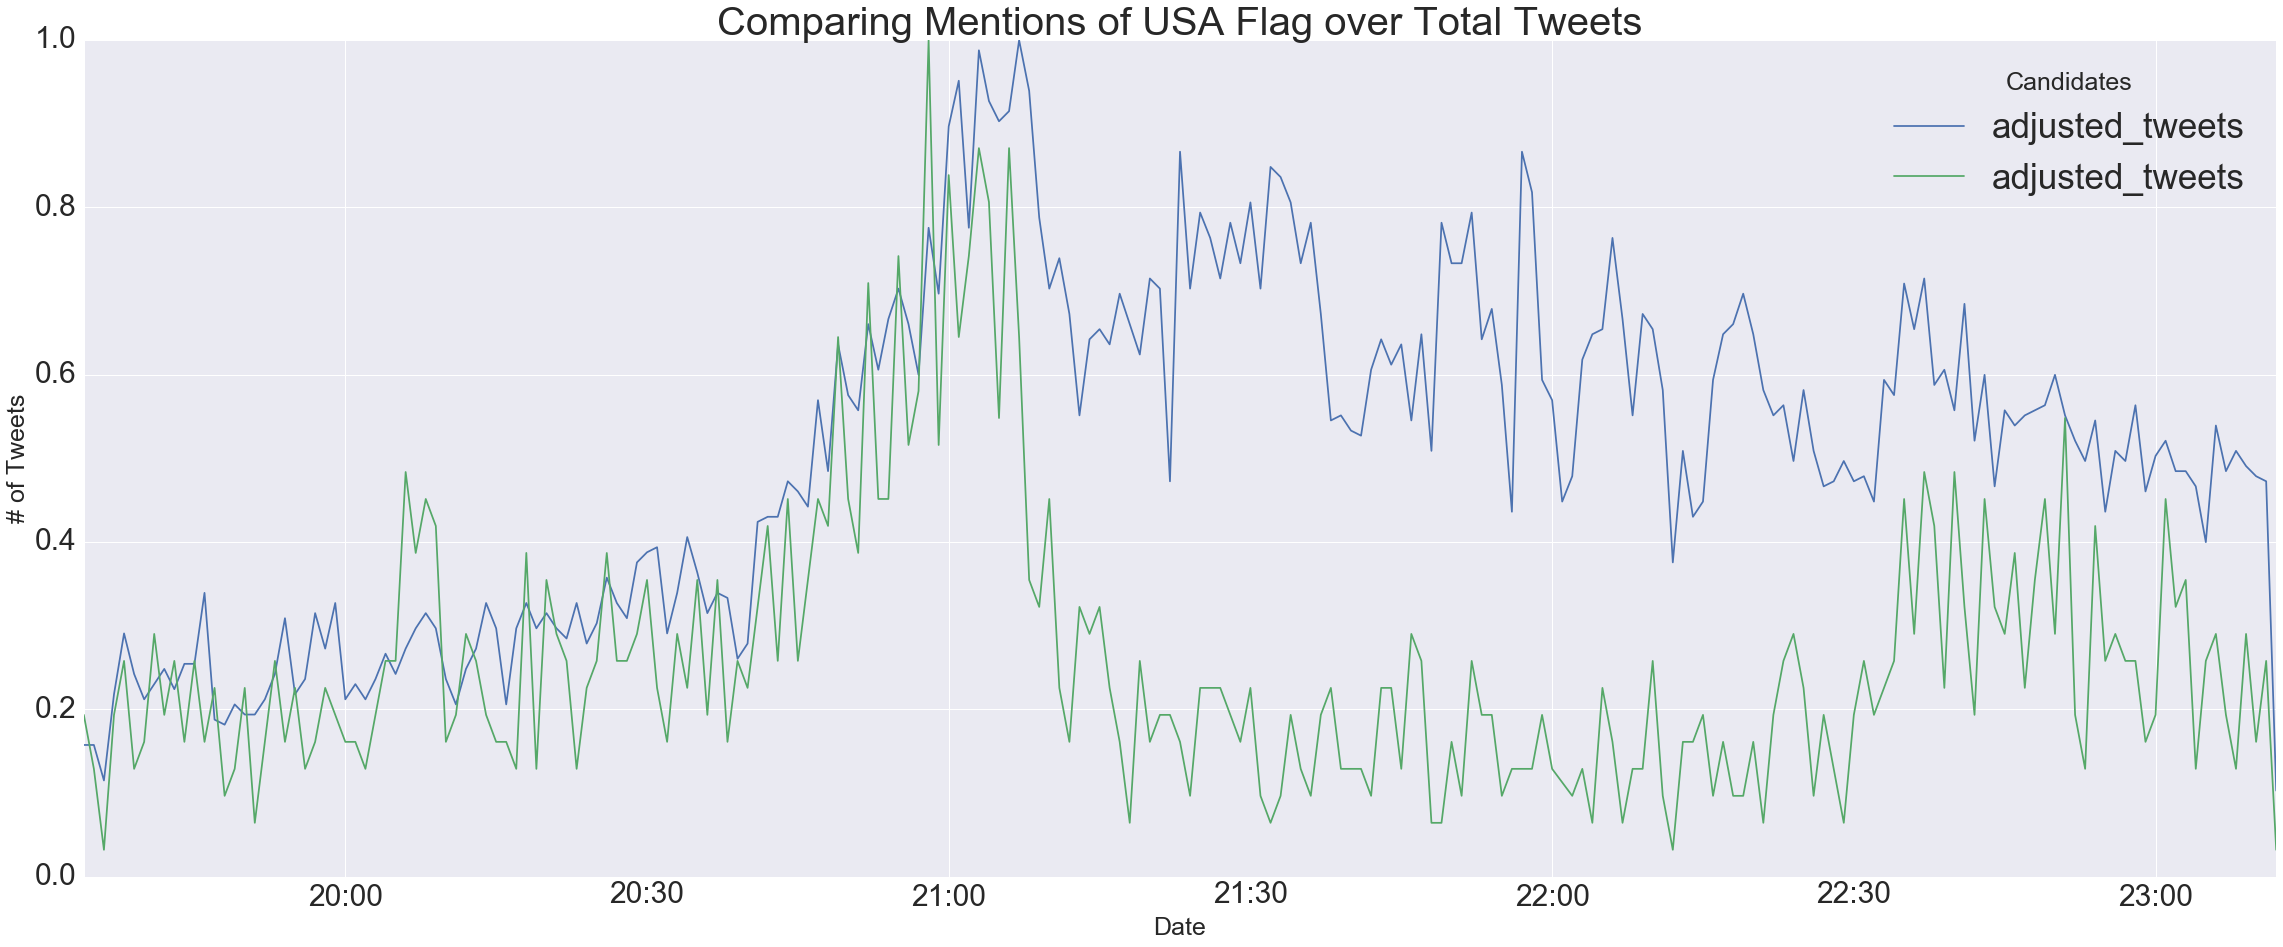

In [121]:
groupby_total_emojis.adjusted_tweets.plot()
groupby_usa.adjusted_tweets.plot()
plt.legend(title = 'Candidates')
plt.title('Comparing Mentions of USA Flag over Total Tweets')
plt.xlabel('Date')
plt.ylabel('# of Tweets')

<b> Takeaways:</b><br>
The USA Emoji has two distinctive peaks, one before and during the beginning of the debate and the second after the debate, one can assume that as people prepare for the debate they are more patriotic while debate issues take hold during the debate and the emoji is not used as frequently.

<i> B. Clapping Hands Emoji

In [122]:
emoji_only_df['clap_hands'] = [1 if (u'\U0001f44f' in emojis) else 0 for emojis in emoji_only_df.emojis]
groupby_clap = emoji_only_df[emoji_only_df.clap_hands == 1].groupby('new_date').count()
groupby_clap['adjusted_tweets'] = [i/float(groupby_clap.text.max()) for i in groupby_clap.text]

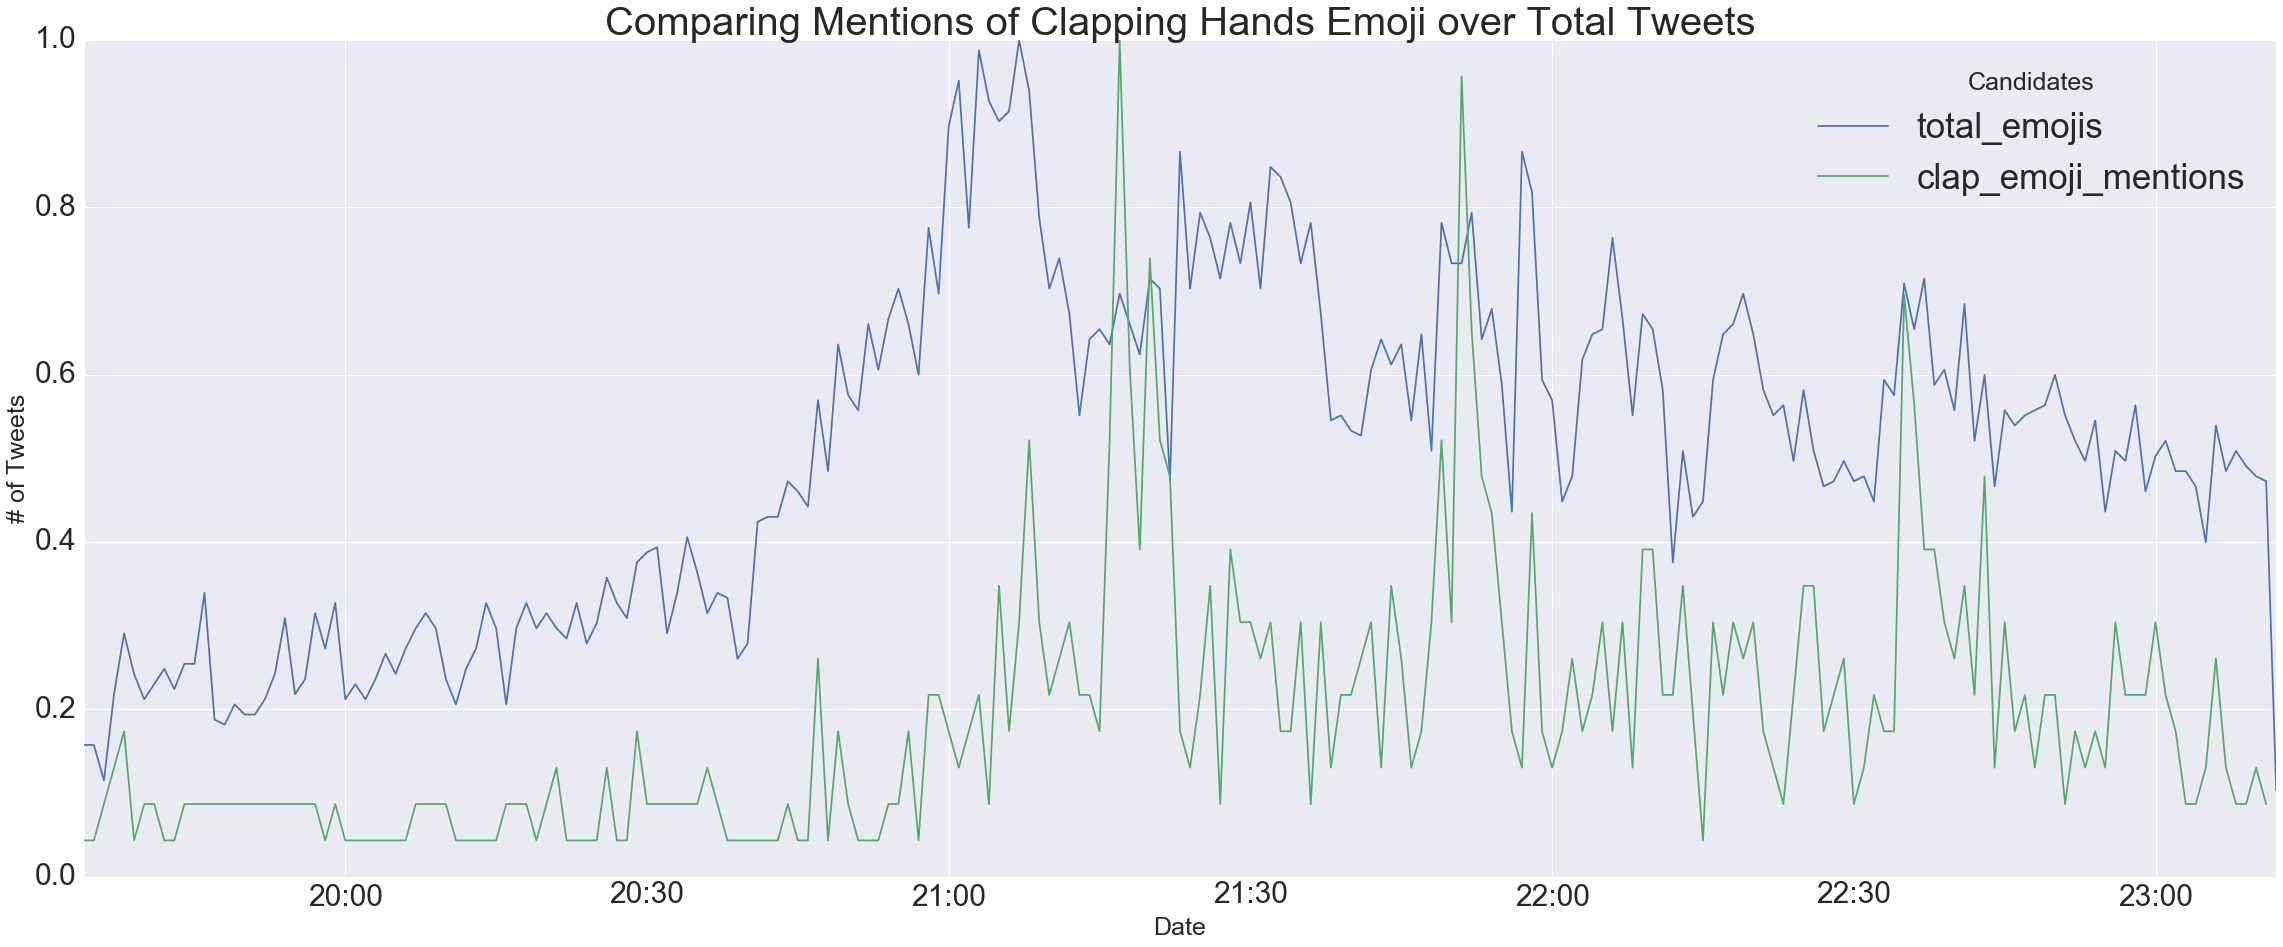

In [124]:
groupby_total_emojis.adjusted_tweets.plot(label = 'total_emojis')
groupby_clap.adjusted_tweets.plot(label = 'clap_emoji_mentions')
plt.legend(title = 'Candidates')
plt.title('Comparing Mentions of Clapping Hands Emoji over Total Tweets')
plt.xlabel('Date')
_ = plt.ylabel('# of Tweets')

<b> Takeaways:</b><br>
The clapping hands emoji in contract to the American Flag has three distinctive peaks during the debate, more likely
correlated with a debate topic. We can look closer in the data and see what those topics where

<b> Implementation:</b>
1. We'll isolate the tweets at the highest point of each each peak by doing a group by of time and then sort the top three highest times.
2. We will then see and make a determination of what they were talking about.

<i>First Spike

In [132]:
# First Spike Time
first_clap_spike = groupby_clap.sort_values('adjusted_tweets', ascending = False).index[0]
print 'The first spike hapenned at %r'%first_clap_spike

The first spike hapenned at Timestamp('2016-10-19 21:17:00')


In [138]:
# The First Spike is About Roe v Wade
for i in emoji_only_df[emoji_only_df.new_date == first_clap_spike].iloc[40:60].text:
    print i

@HillaryClinton wants to fund an org. that sells fetal organs. Verrrry presidential. 🙄 #debate
I Can't Believe Empire Not Coming On Cause Of The Presidential Debate 😩🙄 I Don't Like Hilary Or Trump 😪😑 #Debate
Okay I can't get over it, and I'm not even completely "with her"... But Hilary Clinton looks flawless rn 😍💎 #debate
So far, very calm and I'm scared. Also Hil's white pant suit 👌🏼 #debate
#debate 🇺🇸 https://t.co/3EfVEAELRc
ELECTION NEWS3🐴🐘 •What's the DIFFERENCE between a circus and the election? •The election has only 2 performers🎭 https://t.co/WxnM17IPeD
Turned on telly for a quick.peek, and saw Ms. Hilary in that cream power suit. 💯👊 #debatenight #debate
I would totes make out with you right now for saying that... 😂 https://t.co/7xqm2mRo3w
🙏🏻 https://t.co/Q0DfzwHUQ0
@realDonaldTrump just cannot give any legitimate answers... @HillaryClinton 's eyebrow raises though 😂 #DebateNight
Here we go again with @realDonaldTrump not answering questions 🙄🙄🙄#debatenight
I don't thin @realDon

<b> Takeaways:</b><br>
This is a short snippet and but you can start to see that thi spike is related to be Hillary's responce to Roe v Wade and abortion issues. Her supporters and clapping her backing of responces. I shortened this due to space issues here but I looked at over a couple of hundred and they all lean in this direction

<i>Second Spike

In [144]:
# Second Spike Time
second_clap_spike = groupby_clap.sort_values('adjusted_tweets', ascending = False).index[1]
print 'The second spike hapenned at %r'%second_clap_spike

The second spike hapenned at Timestamp('2016-10-19 21:51:00')


In [154]:
# The Second Spike is About Hillary Mentioning her Experience
for i in emoji_only_df[emoji_only_df.new_date == second_clap_spike].iloc[40:60].text:
    print i

#crocodiletears are what I'm going to have if this bone head really gets elected. 🐊💦 #debate
Watching the #Debate and I call BULLSHIT!!! Where is Bernie?! 🙄
@HillaryClinton is such a warrior for the children yet shes ok with 3rd term abortion?😳🤔#debate
Wow, Trump really is emptyheaded on facts knowledge &amp; ideas. #BlessHisTrolleyHeart🐸 #debate
THAT👏🏻CLAPBACK👏🏻THOUGH👏🏻YES👏🏻 #debate
Ohh girl..I saw that. #Wrong lmfao 😂😂 @realDonaldTrump #PresidentialDebate2016
"Excuse me. My turn." - @realDonaldTrump 😂
I bet @marcorubio is sitting at home going, "who's drinking water now @realDonaldTrump!" LOL! 😂 #debate2016 #debate #debatenight
@realDonaldTrump @HillaryClinton #facts 👏🏼👏🏼👏🏼
Get him @HillaryClinton #debatenight 💪🏿💪🏿💪🏿💪🏿💪🏿
@realDonaldTrump "You talk and you do nothing. Why didn't u do it in the last 30 years? When you were SOS there was 6 billion $ missing!" 👊
@realDonaldTrump would you say your fingers are "Bigly" 😂😂😂
😂😂😂 https://t.co/w39eXAiKq5
@mhonividente  awe Mhoni
Bien Lodise @m

<b> Takeaways:</b><br>
This is again a spike that relates to Hillary Clinton and this time it's her mentioning her experience.

Third Spike

In [151]:
# Third Spike Time
third_clap_spike = groupby_clap.sort_values('adjusted_tweets', ascending = False).index[2]
print 'The third spike hapenned at %r'%second_clap_spike

The third spike hapenned at Timestamp('2016-10-19 21:51:00')


In [153]:
# The Third Spike is Hillary Answering about Women's Rights
for i in emoji_only_df[emoji_only_df.new_date == third_clap_spike].iloc[40:70].text:
    print i

-Mexico supports you @HillaryClinton ❤❤❤ #debatenight #debate ❤❤❤ @katyperry
Is it just me or is the lighting terrible in that room?!?! 💡#debate
It's a women's body and it should be a women's choice!! Fuck you Trump.😑 #debate
🎶It's a tournament a tournament a tournament a tournament of lies...🎶

#debate
Trump, I knew you waited until the last #debate to show your true face. 🤔 https://t.co/zatlUbvlHt
Scare 👏🏽 rhetoric 👏🏽is👏🏽 right👏🏽 #debate https://t.co/vrNmKaBAnd
"I will defend women's rights to make their own healthcare decisions" - @HillaryClinton 🙌🏻
Can't take @realDonaldTrump seriously 😂😂
Don't think she would have worded it like that had Bernie not been such a potent challenger 👍🏻 https://t.co/Xxw1Lq4Vp9
#VIDEO ▶ |  ¡Taqueros le ponen sabor! levantan “muro” frente al Hotel @realDonaldTrump en #LasVegas… https://t.co/kuneDj4YOb
#VIDEO ▶ |  ¡Taqueros le ponen sabor! levantan “muro” frente al Hotel @realDonaldTrump en #LasVegas… https://t.co/148CrS0ufw
Scare rhetoric 😂 ok @HillaryCli

<b> Takeaways:</b><br>
The final spike is also about hillary and it mentions Hillary's defence of women's right. 


<i><u>We can now see how the clapping hands emoji is correlated with Hillary since it appears when we perfomed well in the debate.

# <u> 7. Conclusions

<b> Our Conclusions:</b>
1. Donald Had a much higher volume of tweets overall, relating to both negative and position reactions to him. This also carried over to tweets, which he also had a much higher volume of. 
2. Certain emojis are highly correlated with certain topics. For example: the clapping hands emoji is very correlated with women's right issues and Hillary in general. In a clearere example, the train emoji is used when Trump is seen to be doing well.
3. Aside from english, the top 4 languages are comprised of Spanish, Portuguese, and French. This might be due with a certain community's involvement with this election or areas where twitter is popular.
